# DAQ（v7）

## 変更箇所
- ``Status``データクラス
    - ``UserSettings``クラスの中で使えるように、定義する場所を先頭に移動しました。
    - メンバー変数に ``cpu_tempC`` を追加しました
- ``UserSettings``データクラス
    - メンバー変数の ``trigger_levels`` のデフォルト値を ``[0.1, 0.1]``に変更しました。
    - メンバー変数の ``version``を``7``に変更しました。
    - メンバー変数にの``distance``を追加しました。将来的に、測定時にCW間の距離を記録できるようにしました。
    - ``update``関数でトリガーソースを確認する部分で、想定した値の範囲外となった場合に``ValueError``の例外を発生させることにしました。
        - 何度か繰り返し確認すると、たまにトリガーソースの値が設定されてないことがあるようです
        - ``rp_AcqGetTriggerSrc()``に失敗すると``0``になるので、トリガーはch1にしたほうがよさそうです。
- ``single_event_draw``
    - 描いたタイミングで画像を保存することにしました。
    - 画像の描画＆保存にある程度の処理時間がかかるので、望まない場合はスキップできるようになります
- ``single_event``
    - 関数の引数に ``draw: bool``を追加しました。``single_event_draw``を実行するかしないかの選択に使うことができます。

# ローカル時刻を確認する

- RedPitayaはRTC（リアルタイムクロック）を持たないので、電源をOFFにした時点で、ローカル時刻が停止します。
- 測定を再開したときは、現在の時刻とローカル時刻がずれてないか確認してください。
- 時刻がずれている場合は、次のセルの時刻を現在時刻に修正して、コメントを外して実行してください
  - 時刻を合わせたあとはまたコメントアウトしてください

In [1]:
#!date -s "2024-03-22 16:11:00+09:00"

In [2]:
!date +%Y-%m-%dT%H:%M:%S

2024-03-27T22:38:03


# 切り取り線

In [3]:
def kiritori():
    """関数の区切りを表示するための遊び関数"""
    print("- - 8< - - " * 10)

# CPU温度を取得する

- https://www.scivision.dev/measure-red-pitaya-cpu-temperature-terminal/ のページを参考にした
- Red PitayaのCPU温度データは ``/sys/bus/iio/devices/iio:device0/`` のディレクトリにあった

In [4]:
def read_tempC(fname: str) -> float:
    """
    CPU温度が記録されたファイルの中身を取得する

    Args:
        fname(str): ファイル名
    Returns:
        line(float): ファイルの1行
    """
    p = Path(fname)
    try:
        return float(p.read_text().strip())
    except Exception as e:
        print(f"Error reading {p}: {e}")
        return None

In [5]:
def get_cpu_tempC() -> float:
    """
    CPU温度を計算する

    ( offset + raw) * scale / 1000.0 で計算できる

    Returns:
        tempC(float): CPU温度
    """
    # CPU温度が保存されているパス
    xadc = Path("/sys/bus/iio/devices/iio:device0")
    off = xadc / "in_temp0_offset"
    raw = xadc / "in_temp0_raw"
    scale = xadc / "in_temp0_scale"

    if all(p.exists() for p in [off, raw, scale]):
        offC = read_tempC(off)
        rawC = read_tempC(raw)
        scaleC = read_tempC(scale)

        if offC is not None and rawC is not None and scaleC is not None:
            # 温度を計算してfloatにキャスト
            tempC = float((rawC + offC) * scaleC / 1000.0)
            return tempC
        else:
            print("Failed to read temperature data.")
            return float("nan")  # 計算できない場合はNaNを返す
    else:
        print("One or more required files do not exist.")
        return float("nan")  # 必要なファイルがない場合もNaNを返す

In [6]:
# get_cpu_tempC()

# モジュールをインポートする

- データ取得に必要なPythonモジュールをインストールします
- Pythonノートブックのセッション開始時に、1回だけ実行してください
  - セッションを再起動（リスタート）したときは、再び実行してください

In [7]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import rp
from dataclasses import dataclass, asdict
from pathlib import Path

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"RedPitaya: {rp.rp_GetVersion()}")

NumPy: 1.21.5
Pandas: 1.3.5
RedPitaya: 2.00-30 (73ff4bc8f)


# RedPitayaの初期化

- RedPitayaを初期化して測定の準備を開始します
- 関係ありそうなソースファイル
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/python/rp_overlay.py
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/rp.c
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/acq_handler.c

# DAQの設定値を確認する

- DAQの設定をを確認するためのクラスを作成しました
- 関数の中で``s = Status()``を実行すると、``s``オブジェクトに取得した情報が保存されます
- ``s.show()``で保存された変数を表示できます。
- ひとつの関数の中であれば``s.update()``内容を更新できます

In [8]:
@dataclass
class Status:
    trigger_type: int = -1
    trigger_channel: int = -1
    trigger_level: int = -1
    trigger_delay: int = -1
    decimation: int = -1
    sampling_rate: float = -1.0
    deltaT: float = -1.0
    cpu_tempC: float = -1.0

    def __post_init__(self):
        self.update()

    def update(self):
        """
        設定値を更新して保存する
        """

        kiritori()

        header = "[Status.update]"
        print(header)

        if not rp.rp_IsApiInit():
            rp.rp_Init()
            print(f"{header} Initialized API commands (rp.rp_Init)")

        trigger_type = rp.rp_AcqGetTriggerSrc()[1]
        if trigger_type == rp.RP_TRIG_SRC_CHA_PE:
            trigger_channel = rp.RP_T_CH_1
        elif trigger_type == rp.RP_TRIG_SRC_CHB_PE:
            trigger_channel = rp.RP_T_CH_2
        else:
            trigger_channel = -1
            e = f"{header} Unknown trigger type: {trigger_type}"
            print(e)

        trigger_level = rp.rp_AcqGetTriggerLevel(trigger_channel)[1]

        self.trigger_type = trigger_type
        self.trigger_channel = trigger_channel
        self.trigger_level = trigger_level
        self.trigger_delay = rp.rp_AcqGetTriggerDelay()[1]
        self.decimation = rp.rp_AcqGetDecimation()[1]
        self.sampling_rate = rp.rp_AcqGetSamplingRateHz()[1]
        self.deltaT = 1.0 / self.sampling_rate
        self.cpu_tempC = get_cpu_tempC()

    def show(self):
        """設定値を表示する"""
        kiritori()
        header = "[Status.show]"
        print(header)

        print(f"{header} Trigger type: {self.trigger_type}")
        print(f"{header} Trigger channel: {self.trigger_channel}")
        print(f"{header} Trigger level: {self.trigger_level} [V]")
        print(f"{header} Trigger delay: {self.trigger_delay}")
        print(f"{header} Sampling decimation: {self.decimation}")
        print(f"{header} Sampling rate: {self.sampling_rate} [Hz]")
        print(f"{header} Sampling deltaT: {self.deltaT} [sec]")
        print(f"{header} CPU temperature: {self.cpu_tempC} [C]")

In [9]:
# s = Status()
# s.show()

# 測定に必要はパラメーターを設定する

- デシメーション：データのサンプリング率
- トリガーレベル：トリガーの電圧値と信号の向き
- トリガーの遅延：
- バッファーサイズ（サンプリング数）

In [10]:
@dataclass
class UserSettings:
    channels = [rp.RP_CH_1, rp.RP_CH_2]
    trigger_channels = [rp.RP_T_CH_1, rp.RP_T_CH_2]
    trigger_levels = [0.1, 0.1]
    trigger_type: int = rp.RP_TRIG_SRC_CHA_PE
    trigger_delay: int = 0
    decimation: int = rp.RP_DEC_1
    buffers: int = 16384
    version: int = 7
    rp_version: str = rp.rp_GetVersion()
    now = datetime.datetime.now()
    distance: float = 0.0

    def __post_init__(self):
        self.setup()
        self.update()

    def setup(self):
        """設定を書き込む

        ユーザー設定をRedPitayaに書き込みます。
        メンバー変数を更新（self.update）したときにも必ず実行します。
        """

        kiritori()

        header = "[UserSettings.setup]"
        print(header)

        if not rp.rp_IsApiInit():
            rp.rp_Init()
            print(f"{header} Initialized API commands (rp.rp_Init)")

        print(f"{header} Reset DAQ (rp.rp_AcqReset)")
        rp.rp_AcqReset()

        # パラメーターを設定する
        triggers = zip(self.trigger_channels, self.trigger_levels)
        for ich, iv in triggers:
            print(f"{header} Set trigger channel: {ich} | trigger level: {iv} [V]")
            rp.rp_AcqSetTriggerLevel(ich, iv)

        print(f"{header} Set trigger delay: {self.trigger_delay} [samples]")
        rp.rp_AcqSetTriggerDelay(self.trigger_delay)
        time.sleep(0.1)

        print(f"{header} Set sampling decimation: {self.decimation} [samples]")
        rp.rp_AcqSetDecimation(self.decimation)
        time.sleep(0.1)

        print(f"{header} Start DAQ (rp.rp_AcqStart)")
        rp.rp_AcqStart()
        time.sleep(1)

        print(f"{header} Set trigger type: {self.trigger_type}")
        rp.rp_AcqSetTriggerSrc(self.trigger_type)
        time.sleep(1)

    def update(self):
        """メンバー変数を更新する

        インスタンスを作成したときに実行する。
        メンバー変数を変更したあとも必ず実行する。

        更新されるメンバー変数
        - self.trigger_type
        - self.trigger_delay
        - self.decimation

        追加されるメンバー変数
        - self.nch: チャンネル数
        - self.trigger_channel
        - self.trigger_level
        - self.sampling_rate: サンプリングレート（Hz）
        - self.deltaT: サンプリング間隔（秒）
        - self.fname_prefix: ファイル名のプリフィックス
        """
        kiritori()

        now = datetime.datetime.now()
        self.now = now

        header = "[UserSettings.update]"
        print(f"{header} {now}")
        self.nch = len(self.channels)

        # 現在の設定を Status で取得する
        # 取得した値はすべて UserSettings のメンバー変数に代入する
        s = Status()
        s.show()

        # 更新されるメンバー変数
        self.trigger_type = s.trigger_type
        self.trigger_delay = s.trigger_delay
        self.decimation = s.decimation

        # 追加されるメンバー変数
        self.trigger_channel = s.trigger_channel
        self.trigger_level = s.trigger_level
        self.sampling_rate = s.sampling_rate
        self.deltaT = s.deltaT

        # 現在の設定を使って、ファイル名を生成する
        # channel_name = f"ch{trigger_channel + 1}"
        channel_name = f"src{self.trigger_type}"
        trigger_mv = f"{int(self.trigger_level * 1000)}mV"
        prefix = f"cw_data_v{self.version}"
        prefix = f"{prefix}_{channel_name}_{trigger_mv}"
        dt = now.strftime("%Y%m%d_%H%M%S")
        prefix = f"{prefix}_{dt}"
        self.fname_prefix = prefix

    def show(self):
        """設定値を表示する"""

        kiritori()
        header = "[UseSettings.show]"
        print(header)
        print(f"{header} Timestamp: {self.now}")
        print(f"{header} Number of channels: {self.nch}")
        triggers = zip(self.trigger_channels, self.trigger_levels)
        for ich, iv in triggers:
            print(f"{header} Trigger channel: {ich} | Trigger level: {iv} [V]")
        print(f"{header} Trigger type: {self.trigger_type}")
        print(f"{header} Trigger channel: {self.trigger_channel}")
        print(f"{header} Trigger level: {self.trigger_level}")
        print(f"{header} Trigger delay: {self.trigger_delay}")
        print(f"{header} Sampling decimation: {self.decimation}")
        print(f"{header} Sampling buffer size: {self.buffers} [samples]")
        print(f"{header} Sampling rate: {self.sampling_rate} [Hz]")
        print(f"{header} sampling interval: {self.deltaT} [sec]")
        print(f"{header} CW distance: {self.distance} [mm]")
        print(f"{header} DAQ version: {self.version}")
        print(f"{header} RedPitaya version: {self.rp_version}")
        print(f"{header} Filename prefix: {self.fname_prefix}")

In [11]:
# s = Status()
# s.show()

# c = UserSettings()
# c.show()

# s = Status()
# s.show()

In [12]:
c = UserSettings()
# c.show()

## トリガーチャンネル
# c.trigger_channels = [rp.RP_T_CH_1, rp.RP_T_CH_2]

## トリガーレベル
# c.trigger_levels = [0.40, 0.20]

## トリガーソース
## CHA|CHB : Ch1|Ch2に該当する
## PE : PositiveEdge（立ち上がり）でトリガー
# c.trigger_source = rp.RP_TRIG_SRC_CHA_PE  # 2
# c.trigger_source = rp.RP_TRIG_SRC_CHB_PE  # 4

## トリガー遅延（サンプル点の数）
## 正の数：トリガー点が左に移動する
## 負の数：トリガー点が右に移動する
# c.trigger_delay = 7500

## デシメーション
## サンプリング数を間引く度合い: 2の倍数で指定できる
# c.decimation = rp.RP_DEC_2
# c.decimation = rp.RP_DEC_8

## バッファーサイズ（サンプリング数）
## 最大値：16384
# c.samples = 1500

# 変更した値を設定する
# c.setup()
# c.show()

- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.setup]
[UserSettings.setup] Initialized API commands (rp.rp_Init)
[UserSettings.setup] Reset DAQ (rp.rp_AcqReset)
[UserSettings.setup] Set trigger channel: 0 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger channel: 1 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger delay: 0 [samples]
[UserSettings.setup] Set sampling decimation: 1 [samples]
[UserSettings.setup] Start DAQ (rp.rp_AcqStart)
[UserSettings.setup] Set trigger type: 2
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.update] 2024-03-27 22:38:20.523075
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[Status.update]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[Status.show]
[Status.show

In [13]:
# c.update()
# c.show()
# c.update()
# c.show()
# c.update()
# c.show()

# DAQをセットアップする

- スレッショルドをを途中で変更する例

In [14]:
# c = UserSettings()
# c.trigger_levels = [0.8, 0.8]
# c.setup()
# c.show()

# トリガーがかかるまで待つ

In [15]:
def single_event_trigger() -> int:
    """1イベントのトリガーを待つ"""
    kiritori()
    header = "[single_event_trigger]"
    print(header)

    # トリガーを待つ
    print(f"{header} Waiting for a trigger...")
    print(f"{header}     Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"{header}     Fill state: {rp.rp_AcqGetBufferFillState()}")
    counter = 0

    while 1:
        trigger_state = rp.rp_AcqGetTriggerState()[1]
        counter = counter + 1
        if counter % 1000000 == 0:
            print(f"{header} Loop: {counter}")
        if trigger_state == rp.RP_TRIG_STATE_TRIGGERED:
            break

    print(f"{header} Triggered!")
    print(f"{header}     Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"{header}     Fill state: {rp.rp_AcqGetBufferFillState()}")

    # データがあるか確認する
    while 1:
        if rp.rp_AcqGetBufferFillState()[1]:
            break

    print(f"{header} Got Data")
    return counter

In [16]:
# c = UserSettings()
# single_event_trigger()

# 波形データを読み出す

In [17]:
def single_event_readout(config: UserSettings) -> pd.DataFrame:
    """波形データをデータフレームに変換する

    # チャンネル番号に応じた内部バッファー（osc_cha, osc_chb, osc_chc, osc_chd）
    # チャンネル番号に応じたバッファーを読み出せる（osc_GetDataBufferChA(), ...）
    # チャンネル番号を指定してバッファーを読み出す（getRawBuffer(チャンネル))
    # ADC値を読み出す（rp_AcqGetOldestDataRaw(チャンネル番号, サイズ, バッファー)）
    # 電圧に変換した値を読み出す（rp_AcqGetOldestDataV(チャンネル番号, サイズ, バッファー)）
    """

    kiritori()
    header = "[single_event_readout]"
    print(header)

    # データ処理の開始時刻を取得したいため、内部変数を更新する
    config.update()
    _buffers = config.buffers
    _channels = config.channels
    _version = config.version
    _deltaT = config.deltaT

    # 波形データをデータフレームに変換する
    print(f"{header} Convert waveforms into pd.DataFrame")
    waveforms = {}

    for ich in _channels:
        print(f"{header} Readout Ch{ich}")
        # RAW（ADC値）
        ibuff = rp.i16Buffer(_buffers)
        res = rp.rp_AcqGetOldestDataRaw(ich, _buffers, ibuff.cast())[1]

        # Volts（ADC値を電圧（V）に変換した値）
        fbuff = rp.fBuffer(_buffers)
        res = rp.rp_AcqGetOldestDataV(ich, _buffers, fbuff)[1]

        # データを保存する配列を作成する
        data_raw = np.zeros(_buffers, dtype=int)
        data_volts = np.zeros(_buffers, dtype=float)

        # データをコピーする
        for i in range(0, _buffers, 1):
            data_raw[i] = ibuff[i]
            data_volts[i] = fbuff[i]

        # データを代入する
        key1 = f"raw{ich+1}"
        key2 = f"v{ich+1}"
        waveforms[key1] = data_raw
        waveforms[key2] = data_volts

    print(f"{header} Add columns to pd.DataFrame")
    data = pd.DataFrame(waveforms)
    data["x"] = data.index
    data["time"] = data.index * _deltaT
    data["deltaT"] = data["time"].diff()
    data["totalT"] = data["deltaT"].cumsum()

    return data

In [18]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# data

# カスタマイズ

- 波形データごとのオフセットを補正する
- オフセットの平均値と標準偏差を使ってスレッショルドを計算する
- 各点の電荷を計算する
- TOFを計算する
- 測定時のCPU温度を取得する

# スレッショルドを再計算する

- データの先頭から"100:200"あたりを使ってベースラインを計算する
- ベースラインの平均値と標準偏差を使って、信号の閾値を計算する

In [19]:
def get_threshold(
    data: pd.DataFrame, name: str, width: float = 3.0
) -> tuple[float, float, float]:
    """信号の閾値を計算する
    Args:
        data(pd.DataFrame): 波形データ
        name(str): 計算したいカラム名
        width(float): 閾値の幅
    Returns:
        threshold(float)
    """
    kiritori()
    header = "[get_threshold]"
    print(header)
    copied = data.copy()
    mean = copied[name].mean()
    std = copied[name].std()
    threshold = mean + width * std
    print(f"{header} m: {mean} | s: {std} | t: {threshold}")
    return mean, std, threshold

In [20]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# print(get_threshold(data.iloc[100:200], name="v1"))
# print(get_threshold(data.iloc[100:200], name="v2"))

In [21]:
def discriminator(data: pd.DataFrame, name: str, start: int = 100, end: int = 200):
    kiritori()
    header = "[discriminator]"
    print(header)
    copied = data.copy()

    # オフセット補正
    mean, std, threshold = get_threshold(copied.iloc[start:end], name)
    copied["fixed"] = copied[name] - mean

    # スレショルド補正
    copied["valid"] = 0.0
    isT = copied["fixed"] > threshold
    copied.loc[isT, "valid"] = copied["fixed"]

    # スレッショルドを越えたサンプル数と割合
    N = len(copied)
    T = isT.sum()
    ratio = T / N
    print(f"{header} N: {N} >>> {T} | Selected: {ratio * 100:.2f} %")

    return copied["fixed"], copied["valid"]

In [22]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# data["v1_fixed"], data["v1_valid"] = discriminator(data, name="v1")
# data["v2_fixed"], data["v2_valid"] = discriminator(data, name="v2")
# data

In [23]:
def get_deltaQ(
    data: pd.DataFrame,
    name: str,
    unitV: float = 1.0,
    unitT: float = 1e-6,
    ohmR: float = 50.0,
):
    """サンプルあたりの電荷を計算する
    Args:
        data(pd.DataFrame): 波形データ（スレッショルド適応済み）
        name(str): 計算に使うカラム名（[v1_valid|v2_valid]）
        unitV(float): 測定した電圧の単位（デフォルトは V）
        unitT(float): 測定した時間の単位（デフォルトは 1e-6 s）
        ohmR(float): 測定したときの抵抗値（デフォルトは 50.0 Ohm）
    """
    copied = data.copy()
    unitQ = unitV * unitT / ohmR
    deltaQ = copied[name] * data["deltaT"] * unitQ
    return deltaQ

In [24]:
def add_deltaQ(data: pd.DataFrame):
    """電荷を計算したカラムを追加する"""
    copied = data.copy()

    # Ch1の計算
    copied["v1_fixed"], copied["v1_valid"] = discriminator(data, name="v1")
    copied["q1"] = get_deltaQ(copied, name="v1_valid")

    # Ch2の計算
    copied["v2_fixed"], copied["v2_valid"] = discriminator(data, name="v2")
    copied["q2"] = get_deltaQ(copied, name="v2_valid")

    return copied

# TOFを計算する

- ベースラインとスレッショルド補正した波形データを使う（``v1_valid`` | ``v2_valid``）
- この2つのデータを使って相関関数を計算する

In [25]:
def get_tof(data: pd.DataFrame) -> float:
    """
    Args:
        data(pd.DataFrame): 波形データ（補正済み）
    Returns:
        tof(float): 計算したTOFの値
    """
    copied = data.copy()

    # TODO: ひとまず 0 にした
    tof = 0.0
    return tof

# イベントサマリーを確認する

In [26]:
def single_event_summary(config: UserSettings, data: pd.DataFrame):
    """波形データの最大値を確認する
    Args:
        config(UserSettings): ユーザー設定
        data(pd.DataFrame): 波形データ（補正済み）
    Returns:
        summary(dict): イベントごとのサマリを計算した辞書型オブジェクト
    """

    header = "[single_event_summary]"
    print(f"{header} Check waveforms summary")

    # 電荷を計算する
    q1 = data["q1"].sum()
    q2 = data["q2"].sum()

    # 波高の最大値を取得する
    v1 = data["v1_valid"].max()
    v2 = data["v2_valid"].max()

    # 波高が最大値のインデックス（=X軸）を取得する
    x1 = data["v1_valid"].idxmax()
    x2 = data["v2_valid"].idxmax()

    # TOFを計算する
    tof = get_tof(data)

    # CPU温度を取得する
    cpu_tempC = get_cpu_tempC()

    # データフレームを表示する
    # display(data[x1-10:x1+10])
    print(f"{header} ch1 (x1, v1, q1) = ({x1}, {v1}, {q1})")
    print(f"{header} ch2 (x2, v2, q1) = ({x2}, {v2}, {q2})")

    summary = {
        "x1": x1,
        "v1": v1,
        "q1": q1,
        "x2": x2,
        "v2": v2,
        "q2": q2,
        "tof": tof,
        "cpu_tempC": cpu_tempC,
    }
    return summary

In [27]:
# c = UserSettings()
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# single_event_summary(c, data)

# 波形をグラフにする

In [28]:
def single_event_draw(config: UserSettings, data: pd.DataFrame):
    """波形データを描画する

    信号がありそうな領域にフォーカスしたグラフを作成する。
    そのため、波高が最大値をとる点（インデックス）を探し、その周辺にスライスする。
    """
    kiritori()
    header = "[single_event_draw]"
    print(header)

    copied = data.copy()

    # ファイル名を取得する
    # ファイル名はグラフのタイトルにも使う
    prefix = config.fname_prefix

    # 波高が最大となるインデックスを取得する
    print(f"{header} Get index (X) at the maximum wave height")
    x1 = data["v1"].idxmax()
    x2 = data["v2"].idxmax()

    # その周辺のデータを抽出する
    width = 200
    data1 = copied[x1 - width : x1 + width]
    data2 = copied[x2 - width : x2 + width]

    # データをプロットする
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), layout="constrained")
    fig.suptitle(prefix)
    axs = axs.ravel()

    data1.plot.scatter(x="x", y="raw1", ax=axs[0])
    data1.plot.scatter(x="time", y="v1", ax=axs[1])
    data1.plot.scatter(x="time", y="q1", ax=axs[2], c="green")

    data2.plot.scatter(x="x", y="raw2", ax=axs[3], c="red")
    data2.plot.scatter(x="time", y="v2", ax=axs[4], c="red")
    data2.plot.scatter(x="time", y="q2", ax=axs[5], c="green")

    print(f"{header} {config.fname_prefix}")
    fname = f"data/{prefix}.png"
    fig.savefig(fname)
    print(f"{header} Saved to {fname}")

    return fig, fname

In [29]:
# c = UserSettings()
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# summary = single_event_summary(c, data)
# fig, fname = single_event_draw(c, data)

# データを保存する

In [30]:
def single_event_save(config: UserSettings, data: pd.DataFrame):
    """データフレームを保存する
    Args:
        config(UserSettings): ユーザー設定
        data(pd.DataFrame): 波形データ（いろいろ計算済み）
    Returns:
        saved(dict): 保存したデータのサマリー
    """

    kiritori()
    header = "[single_event_save]"
    print(f"{header} Save data")
    version = config.version
    now = config.now

    data["timestamp"] = now
    data["version"] = version

    fname = f"data/{config.fname_prefix}.csv"
    data.to_csv(fname, index=False)
    print(f"{header} Saved to {fname}")

    saved = {
        "timestamp": now,
        "version": version,
        "rp_version": config.rp_version,
        "csv": fname,
    }

    return saved

In [31]:
# c = UserSettings()
# c.trigger_levels = [0.2, 0.2]
# c.setup()

# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# summary = single_event_summary(c, data)
# fig, png = single_event_draw(c, data)
# saved = single_event_save(c, data)
# saved

In [32]:
def single_event(config: UserSettings, draw: bool):
    """1イベントを取得する
    Args:
        config(UserSettings): ユーザー設定
    Returns:
        saved(dict): イベントサマリー
    """
    kiritori()
    header = "[single_event]"
    print(header)

    # DAQをセットアップする
    config.setup()

    # DAQを実行する
    count = single_event_trigger()
    data = single_event_readout(c)

    # 電荷を計算する
    data = add_deltaQ(data)

    # イベントのサマリーを計算する
    # [x] 波高が最大となるインデックス
    # [x] 波高の最大値
    # [x] 電荷の計算
    # [ ] TOF
    # [x] CPU温度
    summary = single_event_summary(c, data)

    # 波形データを保存する
    saved = single_event_save(config, data)

    # 波形データをグラフに保存する
    if draw:
        fig, png = single_event_draw(c, data)
        saved["png"] = png
    else:
        print(f"{header} Skipped draw...")

    # イベントのサマリーを作成する
    summary["count"] = count
    saved.update(summary)

    # DAQの状態を確認して追加する
    status = Status()
    status.show()
    d = asdict(status)
    saved.update(d)
    time.sleep(1)

    return saved

In [33]:
# c = UserSettings()
# c.trigger_levels = [0.2, 0.2]
# c.trigger_source = rp.RP_TRIG_SRC_CHB_PE  # 4
# status = single_event(c, draw=False)
# status

In [38]:
def loop_events(config: UserSettings, draw: bool, nloop: int = 10):
    """データ取得を繰り返す"""
    kiritori()
    header = "[loop_events]"
    print(header)

    c.setup()

    summary = []
    for i in range(nloop):
        try:
            kiritori()
            print(f"===== Loop: {i+1}/{nloop} =====")
            status = single_event(c, draw)
            status["run_id"] = i + 1
            summary.append(status)
        except KeyboardInterrupt as e:
            print(type(e), e)
            data = pd.DataFrame(summary)
            return data

    kiritori()
    c.update()
    print(f"{header} Save summary as pd.DataFrame")
    data = pd.DataFrame(summary)
    prefix = config.fname_prefix
    fname = f"data/summary_{prefix}.csv"
    data.to_csv(fname, index=False)
    print(f"{header} Saved to {fname}")
    print(f"{header} Finished!")

    return data

- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.setup]
[UserSettings.setup] Reset DAQ (rp.rp_AcqReset)
[UserSettings.setup] Set trigger channel: 0 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger channel: 1 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger delay: 0 [samples]
[UserSettings.setup] Set sampling decimation: 1 [samples]
[UserSettings.setup] Start DAQ (rp.rp_AcqStart)
[UserSettings.setup] Set trigger type: 2
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.update] 2024-03-27 22:40:13.428760
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[Status.update]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[Status.show]
[Status.show] Trigger type: 2
[Status.show] Trigger channel: 0
[Status.

[Error:acq_GetTriggerLevel] Channel is larger than allowed: -1


[single_event_readout] Readout Ch1
[single_event_readout] Add columns to pd.DataFrame
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[discriminator]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[get_threshold]
[get_threshold] m: 0.009327392578125 | s: 0.0015629830239963425 | t: 0.014016341650114027
[discriminator] N: 16384 >>> 93 | Selected: 0.57 %
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[discriminator]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[get_threshold]
[get_threshold] m: 0.440750732421875 | s: 0.000713192021077847 | t: 0.4428903084851086
[discriminator] N: 16384 >>> 0 | Selected: 0.00 %
[single_event_summary] Check waveforms summary
[single_event_summary] ch1 (x1, v1, q1) = (8202, 0.118724365234375, 9.48102929687

[Error:acq_GetTriggerLevel] Channel is larger than allowed: -1


===== Loop: 2/5 =====
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[single_event]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.setup]
[UserSettings.setup] Reset DAQ (rp.rp_AcqReset)
[UserSettings.setup] Set trigger channel: 0 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger channel: 1 | trigger level: 0.1 [V]
[UserSettings.setup] Set trigger delay: 0 [samples]
[UserSettings.setup] Set sampling decimation: 1 [samples]
[UserSettings.setup] Start DAQ (rp.rp_AcqStart)
[UserSettings.setup] Set trigger type: 0
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[single_event_trigger]
[single_event_trigger] Waiting for a trigger...
[single_event_trigger]     Trigger state: [0, 1]
[single_event_trigger]     Fill state: [0, False]
[single_event_trigger] Loop: 1000000
[single_event_tri

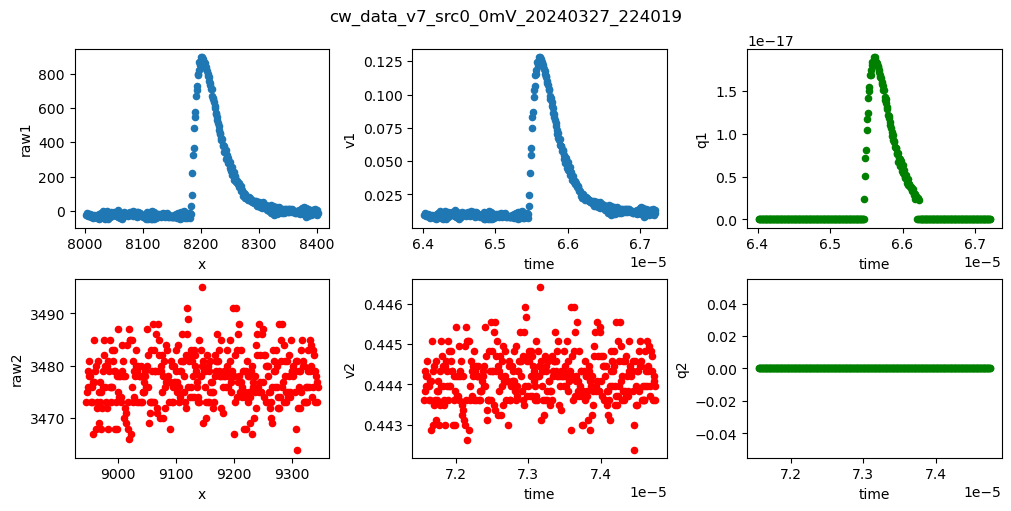

In [37]:
c = UserSettings()
# c.trigger_levels = [0.1, 0.1]
# c.trigger_source = rp.RP_TRIG_SRC_CHA_PE
events = loop_events(c, draw=True, nloop=5)

In [ ]:
events

In [ ]:
events.plot.scatter(x="run_id", y="cpu_tempC")